# Char RNN

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import to_categorical
from collections import Counter

In [2]:
df = pd.read_csv('data/abc_char.csv')
df.head()

,T,M,L,K,body
0,The Enchanted Valley,2/4,1/16,Gm,G3-A (Bcd=e) | f4 (g2dB) | ({d}c3-B) G2-E2 | F...
1,Fare You Well,2/4,1/16,D,f-g | a3-b g3-a | f4 e3-d | d3-c A3-B | c4 d3-...
2,The Little Heathy Hill,C,1/8,Gm,B/2-c/2 | d2 d>-c B2 A-B | (GBAG) F2 D-F | (G>...
3,The Little Girl of my Heart,4/4,1/8,D,F-G | A-dd>-c d2 cd | e-fgg (f2 d>e) | f-d (c/...
4,The Fun at Donnybrook,6/8,1/8,Gm,B/2-A/2 | G>FD C>D^F | G3z2B/2-c/2 | B>cd cAG ...


## 문자 집합 생성

In [3]:
char_vocab = sorted(set(''.join(df['body'].tolist())))
vocab_size = len(char_vocab)
print(char_vocab)

[' ', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Z', '[', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']


In [4]:
char_to_index = dict((char, index) for index, char in enumerate(char_vocab))
print(char_to_index)

{' ': 0, "'": 1, '(': 2, ')': 3, '*': 4, '+': 5, ',': 6, '-': 7, '.': 8, '/': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, ':': 20, ';': 21, '<': 22, '=': 23, '>': 24, 'A': 25, 'B': 26, 'C': 27, 'D': 28, 'E': 29, 'F': 30, 'G': 31, 'H': 32, 'I': 33, 'K': 34, 'L': 35, 'M': 36, 'N': 37, 'O': 38, 'P': 39, 'Q': 40, 'R': 41, 'S': 42, 'T': 43, 'U': 44, 'V': 45, 'X': 46, 'Z': 47, '[': 48, ']': 49, '^': 50, '_': 51, '`': 52, 'a': 53, 'b': 54, 'c': 55, 'd': 56, 'e': 57, 'f': 58, 'g': 59, 'h': 60, 'i': 61, 'k': 62, 'l': 63, 'm': 64, 'n': 65, 'o': 66, 'p': 67, 'r': 68, 's': 69, 't': 70, 'u': 71, 'v': 72, 'w': 73, 'x': 74, 'y': 75, 'z': 76, '{': 77, '|': 78, '}': 79, '~': 80}


In [5]:
index_to_char = {}
for key, value in char_to_index.items():
    index_to_char[value] = key

## 학습 데이터 생성

In [6]:
train_X = 'appl' # 입력 시퀀스
train_y = 'pple' # 예측해야하는 시퀀스

입력 시퀀스에 대해 오른쪽으로 1칸 쉬프트한 시퀀스를 예측해야하는 라벨로 지정

In [7]:
train = df['body'].tolist()

### 시퀀스 길이 지정

In [8]:
print('Minimum sequence length:', min([len(seq) for seq in train]))
print('Maximum sequence length:', max([len(seq) for seq in train]))

Minimum sequence length: 8
Maximum sequence length: 2060


적절한 시퀀스 길이를 설정하기 위해 최대, 최소 시퀀스 길이를 확인   
둘 사이의 간격이 너무 크기 때문에 일부 데이터를 제거하기 위해 우선 길이 분포를 시각화

In [9]:
len_df = df.copy()
len_df['length'] = len_df['body'].apply(lambda x: len(x))
len_df.head()

,T,M,L,K,body,length
0,The Enchanted Valley,2/4,1/16,Gm,G3-A (Bcd=e) | f4 (g2dB) | ({d}c3-B) G2-E2 | F...,371
1,Fare You Well,2/4,1/16,D,f-g | a3-b g3-a | f4 e3-d | d3-c A3-B | c4 d3-...,282
2,The Little Heathy Hill,C,1/8,Gm,B/2-c/2 | d2 d>-c B2 A-B | (GBAG) F2 D-F | (G>...,275
3,The Little Girl of my Heart,4/4,1/8,D,F-G | A-dd>-c d2 cd | e-fgg (f2 d>e) | f-d (c/...,304
4,The Fun at Donnybrook,6/8,1/8,Gm,B/2-A/2 | G>FD C>D^F | G3z2B/2-c/2 | B>cd cAG ...,147


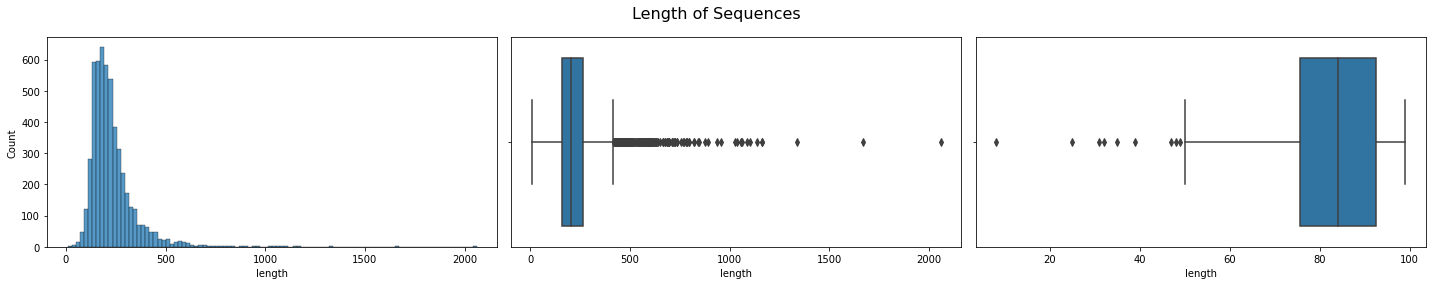

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20,4))
sns.histplot(ax=ax[0], data=len_df, x='length', bins=100)
sns.boxplot(ax=ax[1], data=len_df, x='length')
sns.boxplot(ax=ax[2], data=len_df[len_df['length'] < 100], x='length')
plt.suptitle('Length of Sequences', fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
len_df = len_df[len_df['length'] > 80]
print('Short sequences:', len(df)-len(len_df))

Short sequences: 30


데이터 손실이 적은 시퀀스의 길이를 80으로 설정하고, 길이가 80을 넘지 못하는 30개의 시퀀스를 제거

### 정수 인코딩

In [12]:
train = len_df['body'].tolist()
seq_length = 80

train_X = list()
train_y = list()

for seq in train:
    for i in range((len(seq)-1)//seq_length):
        # 0:80 -> 80:160 -> 160:240로 loop를 돌면서 문장 샘플을 1개씩 pick
        X_sample = seq[i*seq_length:(i+1)*seq_length]

        # 정수 인코딩
        X_encoded = [char_to_index[c] for c in X_sample]
        train_X.append(X_encoded)

        # 오른쪽으로 1칸 쉬프트
        y_sample = seq[i*seq_length+1: (i+1)*seq_length+1]
        y_encoded = [char_to_index[c] for c in y_sample]
        train_y.append(y_encoded)

In [13]:
print('X sample:',train_X[0])
print('y sample:',train_y[0])
print('-'*50)
print('X sample decoded:',[index_to_char[i] for i in train_X[0]])
print('y sample decoded:',[index_to_char[i] for i in train_y[0]])

X sample: [31, 13, 7, 25, 0, 2, 26, 55, 56, 23, 57, 3, 0, 78, 0, 58, 14, 0, 2, 59, 12, 56, 26, 3, 0, 78, 0, 2, 77, 56, 79, 55, 13, 7, 26, 3, 0, 31, 12, 7, 29, 12, 0, 78, 0, 30, 14, 0, 2, 28, 12, 23, 29, 50, 30, 3, 0, 78, 21, 31, 13, 7, 25, 0, 2, 26, 55, 56, 23, 57, 3, 0, 78, 0, 58, 14, 0, 56, 12, 7]
y sample: [13, 7, 25, 0, 2, 26, 55, 56, 23, 57, 3, 0, 78, 0, 58, 14, 0, 2, 59, 12, 56, 26, 3, 0, 78, 0, 2, 77, 56, 79, 55, 13, 7, 26, 3, 0, 31, 12, 7, 29, 12, 0, 78, 0, 30, 14, 0, 2, 28, 12, 23, 29, 50, 30, 3, 0, 78, 21, 31, 13, 7, 25, 0, 2, 26, 55, 56, 23, 57, 3, 0, 78, 0, 58, 14, 0, 56, 12, 7, 58]
--------------------------------------------------
X sample decoded: ['G', '3', '-', 'A', ' ', '(', 'B', 'c', 'd', '=', 'e', ')', ' ', '|', ' ', 'f', '4', ' ', '(', 'g', '2', 'd', 'B', ')', ' ', '|', ' ', '(', '{', 'd', '}', 'c', '3', '-', 'B', ')', ' ', 'G', '2', '-', 'E', '2', ' ', '|', ' ', 'F', '4', ' ', '(', 'D', '2', '=', 'E', '^', 'F', ')', ' ', '|', ';', 'G', '3', '-', 'A', ' ', '(', 'B'

In [14]:
train_X = to_categorical(train_X)
train_y = to_categorical(train_y)

print('train_X shape: {}'.format(train_X.shape)) # 원-핫 인코딩
print('train_y shape: {}'.format(train_y.shape)) # 원-핫 인코딩

train_X shape: (12367, 80, 81)
train_y shape: (12367, 80, 81)


## Modeling

### One-to-One Char RNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

hidden_units = 256

model = Sequential()
model.add(LSTM(hidden_units, input_shape=(None, train_X.shape[2]), return_sequences=True))
model.add(LSTM(hidden_units, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# early_stopping = EarlyStopping(monitor='loss', patience=3)
# cb_checkpoint = ModelCheckpoint(filepath='model/char_rnn_1to1', monitor='accuracy',
#                                 verbose=1, save_best_only=True)

history = model.fit(train_X, train_y, epochs=80,) #callbacks=[cb_checkpoint, early_stopping])

In [33]:
model.save('char_rnn_1to1.h5')

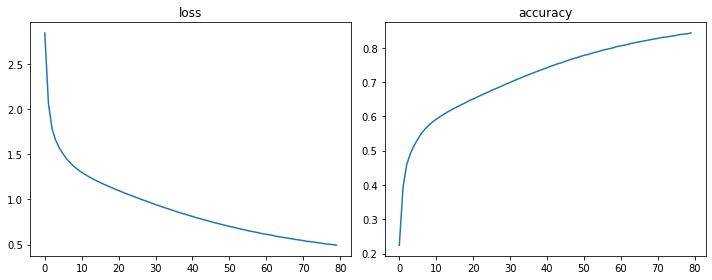

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(history.history['loss'])
ax[0].set_title('loss')
ax[1].plot(history.history['accuracy'])
ax[1].set_title('accuracy')
plt.tight_layout()
plt.show()

In [47]:
def sentence_generation(model, length, ix):
    # 문자에 대한 랜덤한 정수 생성
    # ix = [np.random.randint(vocab_size)]

    # 랜덤한 정수로부터 맵핑되는 문자 생성
    y_char = [index_to_char[ix[-1]]]
    print(ix[-1],'번 문자',y_char[-1],'로 예측을 시작!')

    # (1, length, 55) 크기의 X 생성. 즉, LSTM의 입력 시퀀스 생성
    X = np.zeros((1, length, vocab_size))

    for i in range(length):
        # X[0][i][예측한 문자의 인덱스] = 1, 즉, 예측 문자를 다음 입력 시퀀스에 추가
        X[0][i][ix[-1]] = 1
        print(index_to_char[ix[-1]], end="")
        ix = np.argmax(model.predict(X[:, :i+1, :], verbose=0)[0], 1)
        y_char.append(index_to_char[ix[-1]])
    return ('').join(y_char)

In [50]:
result = sentence_generation(model, 80, [27])
print(result)

27 번 문자 C 로 예측을 시작!
C|F2 A>G FA``A>c|e2 e>e e2 e>c|A2  A>c c2 e>c|c2  A>c e2     A2 |d3 (cBA) G3;A  C|F2 A>G FA``A>c|e2 e>e e2 e>c|A2  A>c c2 e>c|c2  A>c e2     A2 |d3 (cBA) G3;A   


In [51]:
result = sentence_generation(model, 80, [55])
print(result)

55 번 문자 c 로 예측을 시작!
c|BGGA FGAc|BGd>d Gdc:|;cAAe fddf|gfdB cAGF|GB B/B/B (Bc)de|fgaf     gedc|;BGcG c|BGGA FGAc|BGd>d Gdc:|;cAAe fddf|gfdB cAGF|GB B/B/B (Bc)de|fgaf     gedc|;BGcG A


In [52]:
result = sentence_generation(model, 80, [31])
print(result)

31 번 문자 G 로 예측을 시작!
G2 G>G B2 D>B | G>AB>d e>dB<G | A2 A>B A2 :|;B>c | d>BG>B d>BB>g | b2g2 e>fg>e |G2 G>G B2 D>B | G>AB>d e>dB<G | A2 A>B A2 :|;B>c | d>BG>B d>BB>g | b2g2 e>fg>e | 


### Many-to-One Char RNN

In [36]:
train = len_df['body'].tolist()
seq_length = 10

X_data = list()
y_data = list()

for seq in train:
    for i in range((len(seq)-1)//seq_length):
        # 0:80 -> 80:160 -> 160:240로 loop를 돌면서 문장 샘플을 1개씩 pick
        X_sample = seq[i*seq_length:(i+1)*seq_length+1]

        # 정수 인코딩
        X_encoded = [char_to_index[c] for c in X_sample]
        X_data.append(X_encoded[:-1])
        y_data.append(X_encoded[-1])

In [41]:
X_data_one_hot = [to_categorical(encoded, num_classes=vocab_size) for encoded in X_data]
X_data_one_hot = np.array(X_data_one_hot)
y_data_one_hot = to_categorical(y_data, num_classes=vocab_size)

In [42]:
print(X_data_one_hot.shape)

(117766, 10, 81)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

hidden_units = 256

model = Sequential()
model.add(LSTM(hidden_units, input_shape=(X_data_one_hot.shape[1], X_data_one_hot.shape[2])))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=3)
history = model.fit(X_data_one_hot, y_data_one_hot, epochs=100, callbacks=[early_stopping])

In [46]:
model.save('char_rnn_1to1.h5')
pd.DataFrame(history.history).to_csv('char_rnn_mto1', index=False)

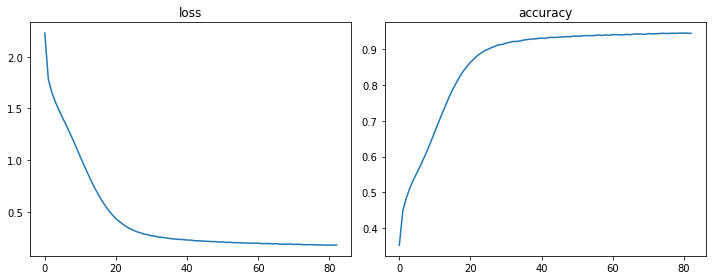

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(history.history['loss'])
ax[0].set_title('loss')
ax[1].plot(history.history['accuracy'])
ax[1].set_title('accuracy')
plt.tight_layout()
plt.show()

In [48]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def sentence_generation(model, char_to_index, seq_length, seed_text, n):

    # 초기 시퀀스
    init_text = seed_text
    sentence = ''

    # 다음 문자 예측은 총 n번만 반복.
    for _ in range(n):
        encoded = [char_to_index[char] for char in seed_text] # 현재 시퀀스에 대한 정수 인코딩
        encoded = pad_sequences([encoded], maxlen=seq_length, padding='pre') # 데이터에 대한 패딩
        encoded = to_categorical(encoded, num_classes=len(char_to_index))

        # 입력한 X(현재 시퀀스)에 대해서 y를 예측하고 y(예측한 문자)를 result에 저장.
        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)

        for char, index in char_to_index.items():
            if index == result:
                break

        # 현재 시퀀스 + 예측 문자를 현재 시퀀스로 변경
        seed_text = seed_text + char

        # 예측 문자를 문장에 저장
        sentence = sentence + char

    # n번의 다음 문자 예측이 끝나면 최종 완성된 문장을 리턴.
    sentence = init_text + sentence
    return sentence

In [50]:
print(sentence_generation(model, char_to_index, 11, 'G>AGE D>EGA', 80))

2022-07-03 19:55:54.741898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-03 19:55:54.806741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


G>AGE D>EGA|BG (3D/2D/2D D2D|D2 D2F2:|A2B2 A2D2|EAAA AcBB|AAeA dedc||;d2((dB))A | (A>B c2) 
